## Install dependencies

In [ ]:
!pip install -qq google-play-scraper

     |████████████████████████████████| 52 kB 1.4 MB/s 


In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 4.4 MB 5.2 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
     |████████████████████████████████| 6.6 MB 47.4 MB/s 
     |████████████████████████████████| 596 kB 67.8 MB/s 


## Import Libs

In [ ]:
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter
from google_play_scraper import Sort, reviews, app

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2), 


## Set up and Configs

In [ ]:
Review_dataset = "reviews.csv"
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
ModelCheckpoint = 'best_model_state.bin'


TEST_VAL_SIZE = 0.1
MAX_LEN = 160
BATCH_SIZE = 16
DROPOUT_P = 0.3
EPOCHS = 15
LEARNING_RATE = 2e-5
SCHEDULER = 'cosine'  #linear/cosine

RANDOM_SEED = 42

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(RANDOM_SEED)

## Read Data and EDA

In [ ]:
df = pd.read_csv(Review_dataset)
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,99974541-f5b2-4b30-8053-77d120d6d6e3,Brent Schoemann,https://play-lh.googleusercontent.com/a/AATXAJ...,I used to love this app. I have used it for ye...,1,35,5.15.4.2,2022-04-25 15:55:21,"Unfortunately, Amazon has rejected our fix and...",2022-04-26 16:53:39,most_relevant,com.anydo
1,ab1187e6-3bfd-4999-a1a5-253baaf58a6a,Anthony Duarte,https://play-lh.googleusercontent.com/a-/AOh14...,"As a programmer, this is absolutely the most l...",1,77,5.15.3.0,2022-01-22 11:33:48,We are sorry you feel this way! We encourage u...,2022-01-24 09:59:17,most_relevant,com.anydo
2,5e2e456d-68b6-4af2-b251-f132a7ea9fb5,Anthony Cannon,https://play-lh.googleusercontent.com/a/AATXAJ...,Redoing my review after messaging with the app...,1,81,5.15.3.0,2022-01-22 13:34:47,"Any.do is a free app, 90% of the app is comple...",2022-01-24 09:58:12,most_relevant,com.anydo
3,e056d73d-0ff3-4890-8848-8cfdfb63b7be,Emie Hickman,https://play-lh.googleusercontent.com/a-/AOh14...,After a task is done a duplicate will appear f...,1,1,NaN,2022-02-22 03:24:11,We would be happy to help you resolve all of t...,2022-02-24 16:34:04,most_relevant,com.anydo
4,a6b21375-312e-41b5-90ab-3d56273ca01b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This app was great until the latest update and...,1,24,4.12.0.5,2019-01-12 13:20:28,"We are sorry you feel this way, please note th...",2019-01-27 15:44:37,most_relevant,com.anydo


In [ ]:
df.shape

(17166, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17166 entries, 0 to 17165
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              17166 non-null  object
 1   userName              17166 non-null  object
 2   userImage             17166 non-null  object
 3   content               17166 non-null  object
 4   score                 17166 non-null  int64 
 5   thumbsUpCount         17166 non-null  int64 
 6   reviewCreatedVersion  14488 non-null  object
 7   at                    17166 non-null  object
 8   replyContent          9068 non-null   object
 9   repliedAt             9068 non-null   object
 10  sortOrder             17166 non-null  object
 11  appId                 17166 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.6+ MB


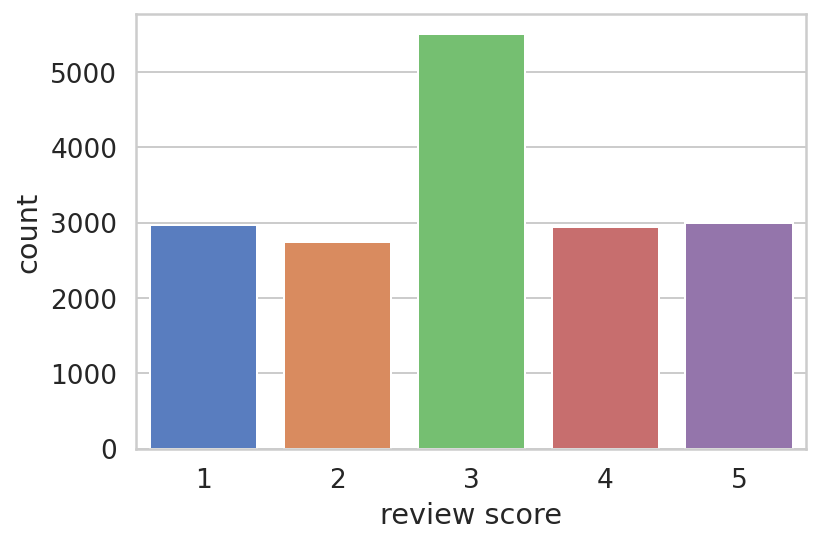

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score');

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2
    
df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

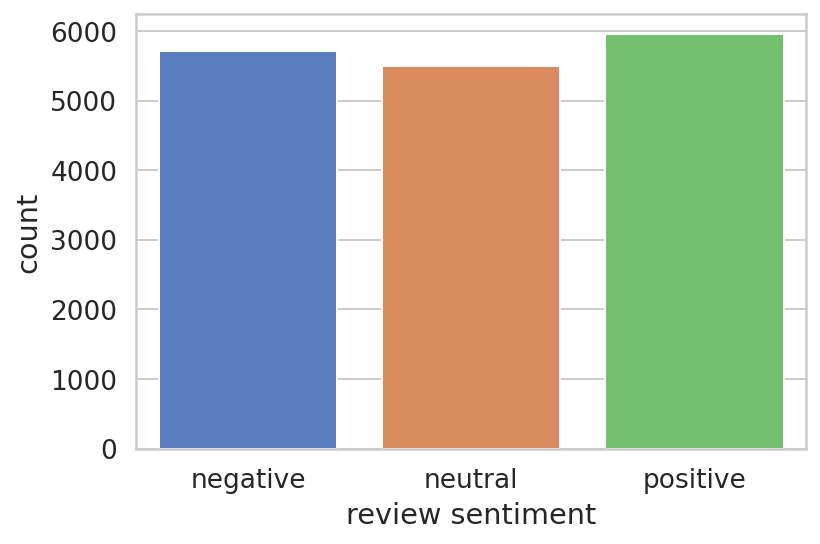

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

## Data Preprocessing

In [ ]:
# PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]


32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
token_lens = []
for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

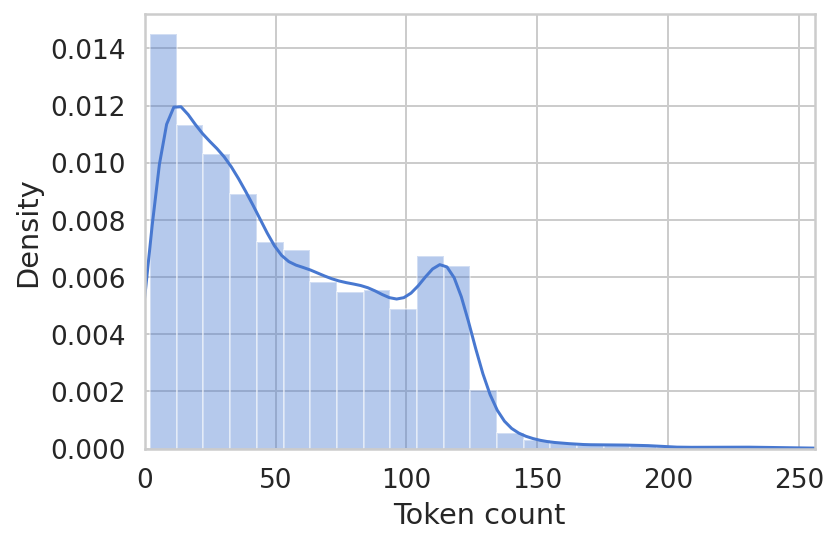

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
# MAX_LEN = 160
# BATCH_SIZE = 16

## Custom Dataset

In [ ]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

## Split Data into train valid test set

In [ ]:
# df = df.sample(1000)
df_train, df_test = train_test_split(df, test_size=TEST_VAL_SIZE, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((15449, 13), (858, 13), (859, 13))

## Dataloader

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
# BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
print(len(train_data_loader))
print(len(val_data_loader))
print(len(test_data_loader))

966
54
54


In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## BERT Model

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# encoding['attention_mask']

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  return_dict=False
)

In [ ]:
last_hidden_state.shape, pooled_output.shape

(torch.Size([1, 32, 768]), torch.Size([1, 768]))

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(p=DROPOUT_P)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids, attention_mask, return_dict=False)
        output = self.dropout(pooled_output)
        output = self.linear(output)
        return output
        # result = self.softmax(output)
        # return result

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [ ]:
model(input_ids, attention_mask)

tensor([[-0.7957, -0.2639, -0.4215],
        [-0.4205, -0.1955,  0.2180],
        [-0.1586, -0.4725,  0.0211],
        [-1.1869, -0.5239, -0.4521],
        [ 0.2850, -0.7816, -0.7479],
        [-1.1580, -0.5717, -0.8421],
        [-0.7631, -0.5671, -0.3903],
        [-0.8057, -1.1608, -0.6273],
        [-0.2716, -1.0182, -0.1740],
        [-0.0368, -0.7181,  0.0388],
        [-0.5544, -0.9697, -0.2181],
        [-0.3997, -0.9888, -0.0741],
        [-1.0223, -0.4415, -0.5672],
        [-0.7929, -0.8696, -0.4470],
        [-0.4401, -0.8616, -0.2720],
        [-1.2305, -0.4636, -0.0062]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## Training Hyperparameters

In [ ]:
# EPOCHS = 15
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

if(SCHEDULER = 'linear'):
  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps= int((total_steps*6)/100),
    num_training_steps=total_steps
  )
elif (SCHEDULER = 'cosine'):
  scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps= int((total_steps*6)/100),
    num_training_steps=total_steps
  )
  
loss_fn = nn.CrossEntropyLoss().to(device)

## Training Validiation Functions

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in tqdm(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in tqdm(data_loader):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

## Start Training

In [ ]:

history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 20)
  print('Training')
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss: {train_loss} Train accuracy: {train_acc}')
  print()
  print('Validation')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val loss: {val_loss} Val accuracy: {val_acc}')
  print()
  history['train_acc'].append(train_acc.cpu().numpy())
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc.cpu().numpy())
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    print(f'Validation acc improved! {best_accuracy} --------> {val_acc}')
    torch.save(model.state_dict(), ModelCheckpoint)
    best_accuracy = val_acc
    print('Model Saved!')
    print()
  # print(train_acc)
  # print(history['train_acc'])



Epoch 1/15
----------


100%|██████████| 966/966 [06:52<00:00,  2.34it/s]


Train loss 0.7590461090423058 accuracy 0.6568709948864004


100%|██████████| 54/54 [00:08<00:00,  6.45it/s]


Val   loss 0.6389279801536489 accuracy 0.7354312354312355

Epoch 2/15
----------


100%|██████████| 966/966 [07:03<00:00,  2.28it/s]


Train loss 0.473870636054602 accuracy 0.8162987895656677


100%|██████████| 54/54 [00:08<00:00,  6.41it/s]


Val   loss 0.6577448889061257 accuracy 0.7575757575757576

Epoch 3/15
----------


100%|██████████| 966/966 [07:04<00:00,  2.28it/s]


Train loss 0.2996777694852633 accuracy 0.8974690918506052


100%|██████████| 54/54 [00:08<00:00,  6.42it/s]


Val   loss 0.8233421328994963 accuracy 0.7785547785547785

Epoch 4/15
----------


100%|██████████| 966/966 [07:03<00:00,  2.28it/s]


Train loss 0.21573958064956825 accuracy 0.934688329341705


100%|██████████| 54/54 [00:08<00:00,  6.43it/s]


Val   loss 0.9677605438736026 accuracy 0.7925407925407926

Epoch 5/15
----------


100%|██████████| 966/966 [07:02<00:00,  2.29it/s]


Train loss 0.1607303808259587 accuracy 0.955984206097482


100%|██████████| 54/54 [00:08<00:00,  6.44it/s]


Val   loss 1.1001444258727133 accuracy 0.8006993006993007

Epoch 6/15
----------


100%|██████████| 966/966 [07:03<00:00,  2.28it/s]


Train loss 0.12516035200124384 accuracy 0.9651757395300666


100%|██████████| 54/54 [00:08<00:00,  6.41it/s]


Val   loss 1.0622336433993445 accuracy 0.7937062937062938

Epoch 7/15
----------


100%|██████████| 966/966 [07:03<00:00,  2.28it/s]


Train loss 0.10885919861158783 accuracy 0.9712602757460029


100%|██████████| 54/54 [00:08<00:00,  6.41it/s]


Val   loss 1.2300614980049431 accuracy 0.7972027972027972

Epoch 8/15
----------


100%|██████████| 966/966 [07:03<00:00,  2.28it/s]


Train loss 0.08211427261750648 accuracy 0.9770858955272186


100%|██████████| 54/54 [00:08<00:00,  6.41it/s]


Val   loss 1.3105558192322928 accuracy 0.8123543123543123

Epoch 9/15
----------


100%|██████████| 966/966 [07:03<00:00,  2.28it/s]


Train loss 0.07182680418902038 accuracy 0.9799987054178264


100%|██████████| 54/54 [00:08<00:00,  6.46it/s]


Val   loss 1.280729308086275 accuracy 0.8158508158508159

Epoch 10/15
----------


100%|██████████| 966/966 [07:02<00:00,  2.28it/s]


Train loss 0.059052346544370984 accuracy 0.9827820570910738


100%|██████████| 54/54 [00:08<00:00,  6.44it/s]


Val   loss 1.283734106493217 accuracy 0.8228438228438228

Epoch 11/15
----------


100%|██████████| 966/966 [07:03<00:00,  2.28it/s]


Train loss 0.049526663959362206 accuracy 0.9847886594601593


100%|██████████| 54/54 [00:08<00:00,  6.42it/s]


Val   loss 1.3423765554325655 accuracy 0.8158508158508159

Epoch 12/15
----------


100%|██████████| 966/966 [07:03<00:00,  2.28it/s]


Train loss 0.04362771085743777 accuracy 0.9863421580684834


100%|██████████| 54/54 [00:08<00:00,  6.43it/s]


Val   loss 1.4319457228735297 accuracy 0.8146853146853147

Epoch 13/15
----------


100%|██████████| 966/966 [07:03<00:00,  2.28it/s]


Train loss 0.04524752524292043 accuracy 0.9855654087643213


100%|██████████| 54/54 [00:08<00:00,  6.44it/s]


Val   loss 1.440485015308864 accuracy 0.817016317016317

Epoch 14/15
----------


100%|██████████| 966/966 [07:03<00:00,  2.28it/s]


Train loss 0.03302153152169989 accuracy 0.9881545731115282


100%|██████████| 54/54 [00:08<00:00,  6.42it/s]


Val   loss 1.468540506928952 accuracy 0.8181818181818182

Epoch 15/15
----------


100%|██████████| 966/966 [07:03<00:00,  2.28it/s]


Train loss 0.032069966468935826 accuracy 0.9885429477636093


100%|██████████| 54/54 [00:08<00:00,  6.44it/s]


Val   loss 1.4720771411860671 accuracy 0.8228438228438228



## Plot Result

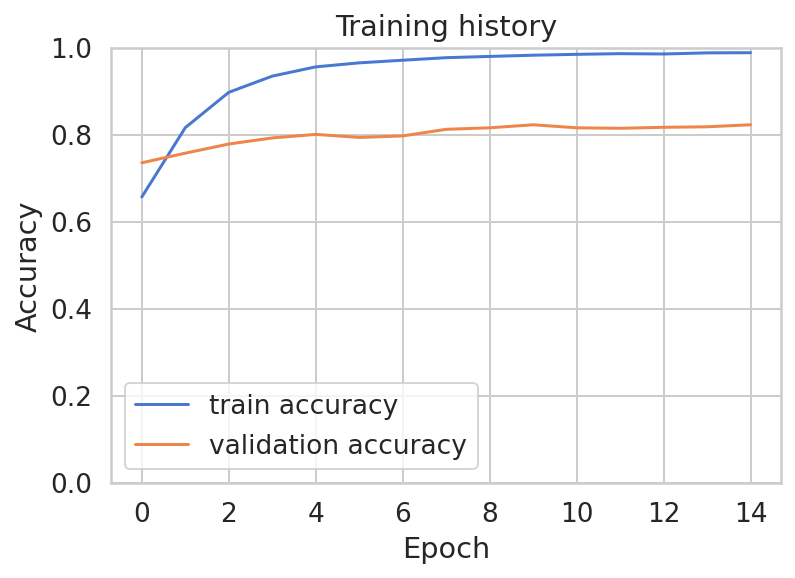

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA
# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load(ModelCheckpoint))
# model = model.to(device)

## Evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

100%|██████████| 54/54 [00:08<00:00,  6.43it/s]


0.7986030267753201

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.84      0.82      0.83       290
     neutral       0.70      0.76      0.73       264
    positive       0.85      0.81      0.83       305

    accuracy                           0.80       859
   macro avg       0.80      0.80      0.80       859
weighted avg       0.80      0.80      0.80       859



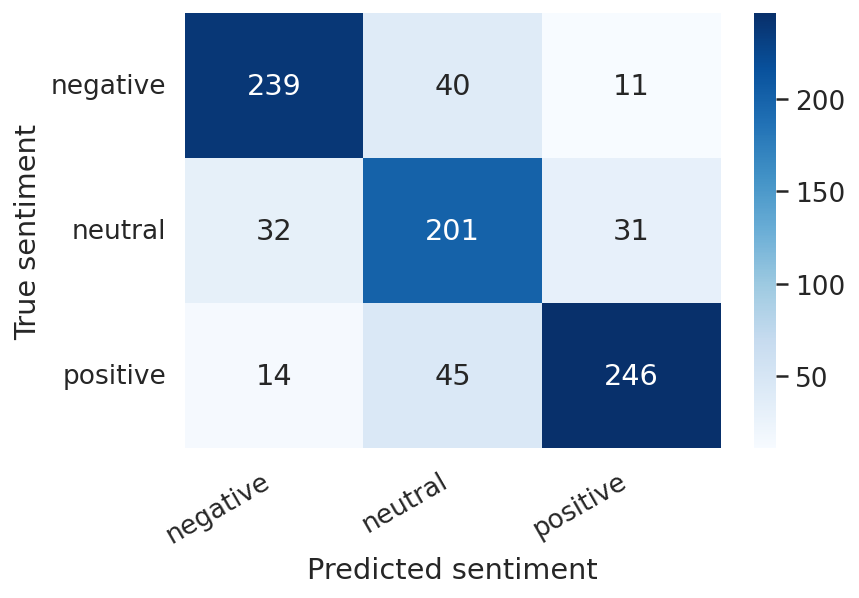

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

helps me stay on track and does its job. definitely recommend it

True sentiment: positive


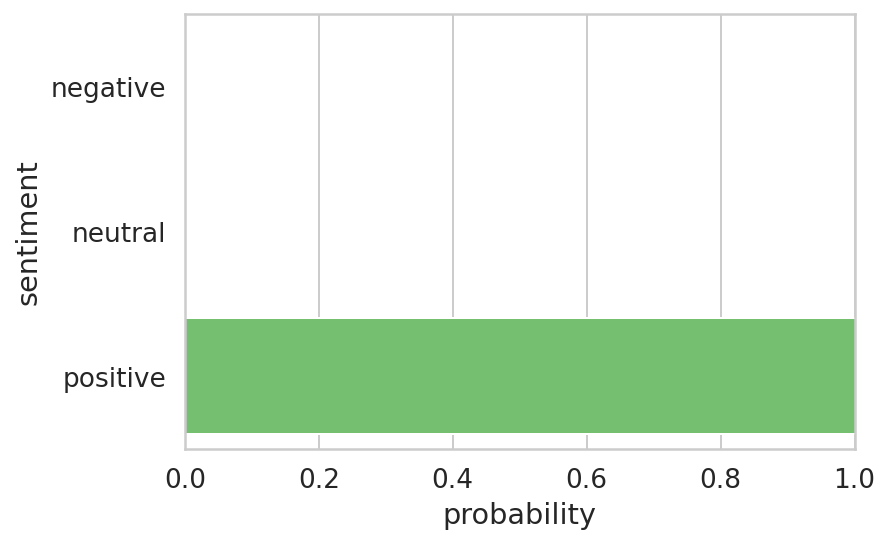

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')


Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
